# Gas2VecKNN

take the gas2vec peak and spectral vectors and

1. compute cosine similarity between discovered peaks' vectors and all others

2. get spectral embedding of discovered peaks, compute cosine similarity against all others



## Settings

In [30]:
base = "data"
dataset = "nist"
kind = "in_database"


wv_path = f"gas2vec/{kind}.model"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from gensim.models import Word2Vec

w2v = Word2Vec.load(wv_path)
vocab = {e:i for i, e in enumerate(w2v.wv.index2entity)}


## Data loading

In [32]:
from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument
from data_utils import spectrum_processing
from data_utils import IntegerMzCoder, TextMzCoder, TopKDS, GenDS

### Spectral data at integer precision

In [33]:
def load_process_documents(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]
    return documents
#documents_train = load_process_documents(data_train_path)
documents_val = load_process_documents(data_val_path)
documents_test = load_process_documents(data_test_path)



In [34]:
datasets = {
   # "gen_train": GenDS(documents_train, vocab, onehot=False), 
    "gen_val": GenDS(documents_val, vocab, onehot=False), 
    "gen_test": GenDS(documents_test, vocab,onehot=False), 
}

## Models definition

In [35]:
from helpers import get_top_k_ind
from collections import Counter
import numpy as np


# def get_occurence(data):
#     all_ = []
#     for i in range(len(data)):
#         all_ += data[i].words
#     return all_, Counter(all_)


# all_, occurences = get_occurence(documents_train)
# words, counts = np.array(sorted(zip(occurences.keys(), occurences.values() ), key=lambda x: x[0])).T
# counts = counts.astype(int)
# rel_freqs = counts/counts.sum()

# coder = TextMzCoder(w2v)

# index2relfreq = np.zeros(len(w2v.wv.index2entity))
# indices, kept = coder.encode(words)
# index2relfreq[indices] = rel_freqs[kept]


In [36]:
# import seaborn as sns
# sns.scatterplot(y=coder.transform_to_mz(index2relfreq, 0), x=np.arange(1,len(coder.transform_to_mz(index2relfreq, 0))+1))

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

class PeakKNN():
    def __init__(self, w2v, weighted=True, weight_power=.5, index2relfreq=None):
        self.w2v = w2v
        self.embeddings = w2v.wv.vectors
        self.weighted = weighted
        self.weight_power = weight_power
        self.index2relfreq = index2relfreq
 
        
    def __call__(self, indices_batch, intens_batch=None, prior=False):
        """
        indices_batch: list of np arrays containing embedding indices of peaks
        """
        
        res = np.zeros(shape=(len(indices_batch), len(self.embeddings)))
        for i, indices in enumerate(indices_batch):
            # drop -1 values
            # mask = indices != -1
            # indices = indices[mask]
            # intens_batch[i] = intens_batch[i][mask]
            
            sim_matrix = self.embeddings[indices] @ self.embeddings.T
            
            if not self.weighted:
                weights = np.ones_like(indices)
            else:
                weights = intens_batch[i]**self.weight_power  
            
            # weighted sum
            res[i] = (sim_matrix.T @ weights).T  
            
#             if prior:
#                 res[i] *= self.index2relfreq
            
            res[i] /= abs(res[i]).max()
        # return distributions vectors over peaks in embedding matrix 
        return res

In [50]:
class SpectralKNN():
    def __init__(self, w2v, intensity_weighting_power=0.5, index2relfreq=None):
        self.w2v = w2v
        self.embeddings = w2v.wv.vectors
        self.intensity_weighting_power= intensity_weighting_power
        
        self.index2relfreq = index2relfreq

    def calculate_gas2vec_embbedding(self, vectors, intens):
        weights_raised = np.power(intens, self.intensity_weighting_power)
        
        return np.sum(vectors.T* weights_raised, 1)
    
    def __call__(self, indices_batch, intens_batch, prior=False):
        """
        indices_batch: list of np arrays containing embedding indices of peaks
        """
        
        res = np.zeros(shape=(len(indices_batch), len(self.embeddings)))
        for i, indices in enumerate(indices_batch):
#             # drop -1 values
#             mask = indices != -1
#             indices = indices[mask]
#             intens_batch[i] = intens_batch[i][mask]            
            
            s_embedding = self.calculate_gas2vec_embbedding(self.embeddings[indices], 
                                                            intens_batch[i])
            
            res[i] = cosine_similarity(s_embedding.reshape(1,-1), self.embeddings)
            
#             if prior:
#                 res[i] *= self.index2relfreq
#             if res[i].sum() == 0:
#                 continue

#             res[i] /= res[i].sum()
#         # return distributions vectors over peaks in embedding matrix 
        return res

## Training
Not necessary here.

## Prediction

In [51]:
class PredictorKNN():
    def __init__(self, model, coder_class, max_mz):
        self.model = model
        self.coder = coder_class(model.w2v, max_mz)
        self.add_intensity = True
    
    def predict(self, indices, intensities):
        return self.model([indices], [intensities])
    
    def predict_ith_from_batch(self, docs, i):
        return self.model([self.coder.encode(docs[i].words)], [np.array(docs[i].weights)])
        
    def predict_batch(self, docs):
        res = np.empty((len(docs), self.coder.get_embedding_dimension()))
        encoded = []
        ints = []
        for doc in docs:
            enc, kept = self.coder.encode(doc.words)
            encoded.append(enc)
            ints.append(np.array(doc.weights)[kept])
            
        res = self.model(encoded, ints)
        return res
    
    def __call__(self, X_ds):
        indices_xs, intens_xs = np.array(X_ds[:,:,0], dtype=int), np.array(X_ds[:,:,1])
        return self.model(indices_xs, intens_xs)
    
    def predict_l_next(self, indices, intens, l, filtered=True):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        pred_indices = self.model([indices], [intens])[0]
        
        if not filtered:
            return get_top_k_ind(pred_indices, l)[0]
        # all peaks must be unique
        #np.unique(data
        
        # omit the peaks that were given as input
        top_k_l = get_top_k_ind(pred_indices, l+len(indices))[0]
        indices_match = set(indices)
        return np.array([ind for ind in top_k_l if ind not in indices_match][:l])
    
    def predict_l_all(self, gen_ds, up_to_k, l, filtered = True, verbose=False, **kwargs):
        l_pred_indices_per_k = np.ones(shape=(up_to_k, len(gen_ds), l)) * (-1)
        y_indices = []
        X_intens = []
        for i in range(len(gen_ds)):
            X_ds, y_ds = gen_ds[i]
            indices, intens = X_ds[:,0].numpy().astype(int), X_ds[:,1].numpy()
            y_indices.append(y_ds.numpy().astype(int))
            X_intens.append(intens)
            for j in range(1, up_to_k+1):
                # we skip evaluation for too short spectra
                if j > len(indices):
                    continue
                l_next = self.predict_l_next(indices[:j], intens[:j], l, filtered)
                l_pred_indices_per_k[j-1,i] = l_next
            if verbose and i % (len(gen_ds)//10) == 0:
                print(f"Done: {i}/{len(gen_ds)}")
        return l_pred_indices_per_k, y_indices, X_intens     

## Visualisation

In [52]:
from visual_utils import plot_spectrum_predictions

predictor = PredictorKNN(PeakKNN(w2v), TextMzCoder, max_mz=None)

i = 5545
k = 5

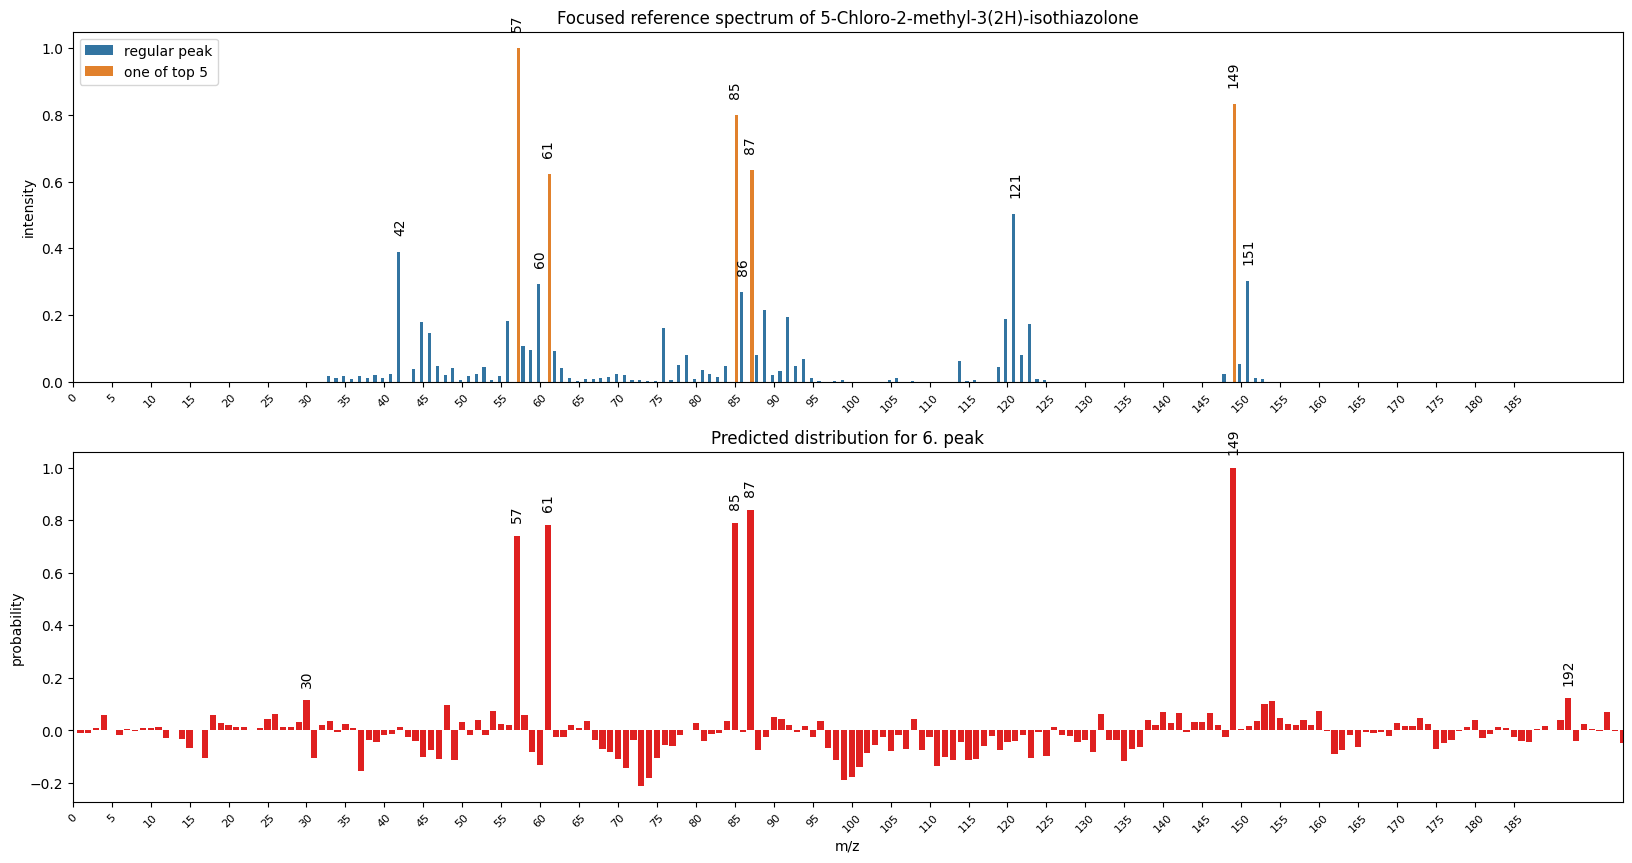

In [53]:
plot_ds = TopKDS(documents_val, vocab, k, onehot=False)
prob = predictor(plot_ds[i][0].reshape(1, *plot_ds[i][0].shape))[0]
plot_spectrum_predictions(plot_ds.ref_docs[i], k, prob, predictor.coder, plot_full=False)

## Model Selection
done on the val set

In [54]:
import os
from metrics import metrics_klj, metrics_intlj

predictors = {"peakknn": PredictorKNN(PeakKNN(w2v,index2relfreq=None), TextMzCoder, max_mz=None), 
              "specknn": PredictorKNN(SpectralKNN(w2v, index2relfreq=None), TextMzCoder, max_mz=None)
             }


P_FOLDER = f"predictions/{kind}"
up_to_k = 30
l = 20

In [55]:
from model_evaluation import calc_predictions, load_predictions, model_selection
from visual_utils import plot_scores

In [56]:
%%time
calc_predictions(up_to_k, l, predictors, datasets, "gen_val", P_FOLDER, verbose=False)

peakknn


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


specknn


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 23min 56s, sys: 817 ms, total: 23min 57s
Wall time: 23min 59s


In [ ]:
best_p_name, scores = model_selection(P_FOLDER, "gen_val", predictors=predictors, up_to_k=20, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)
plot_scores(scores, metrics="mpi")

specknn
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
[22921 22921 22921 22921 22884 22854 22818 22771 22714 22640 22575 22507
 22415 22305 22206 22070 21926 21777 21630 21453]
[22921 22921 22921 22921 22884 22854 22818 22771 22714 22640 22575 22507
 22415 22305 22206 22070 21926 21777 21630 21453]
Selected up to k=20, l=None, to_rel_inten=0.2
[22921 22892 22823 22709 22590 22431 22230 22003 21762 21540 21306 21026
 20781 20543 20298 20051 19808 19580 19368 19131]
[22921 22892 22823 22709 22590 22431 22230 22003 21762 21540 21306 21026
 20781 20543 20298 20051 19808 19580 19368 19131]
peakknn
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
[22921 22921 22921 22921 22884 22854 22818 22771 22714 22640 22575 22507
 22415 22305 22206 22070 21926 21777 21630 21453]
[22921 22921 22921 22921 22884 22854 22818 22771 22714 22640 22575 22507
 22415 22305 22206 22070 21926 21777 21630 21453]
Selected up to k=20, l=None, to_rel_inten=0.2


In [ ]:
best_p_name

## Visualisation of the best predictor

In [ ]:
best_p_name

In [ ]:
prob = predictors[best_p_name](plot_ds[i][0].reshape(1, *plot_ds[i][0].shape))[0]
plot_spectrum_predictions(plot_ds.ref_docs[i], k, prob, predictors[best_p_name].coder)

## Detailed evaluation of the best predictor 
done on the test set

In [ ]:
%%time
up_to_k = 50
l = l
calc_predictions(up_to_k, l, {best_p_name: predictors[best_p_name]}, "hugg_test", P_FOLDER)

In [86]:
l_pred_indices_per_k_best, y_indices, X_intens = load_predictions(best_p_name, "hugg_test", P_FOLDER)
l_pred_indices_per_k_base, y_indices_base, X_intens_base = load_predictions("base_1", "spec_test", P_FOLDER)

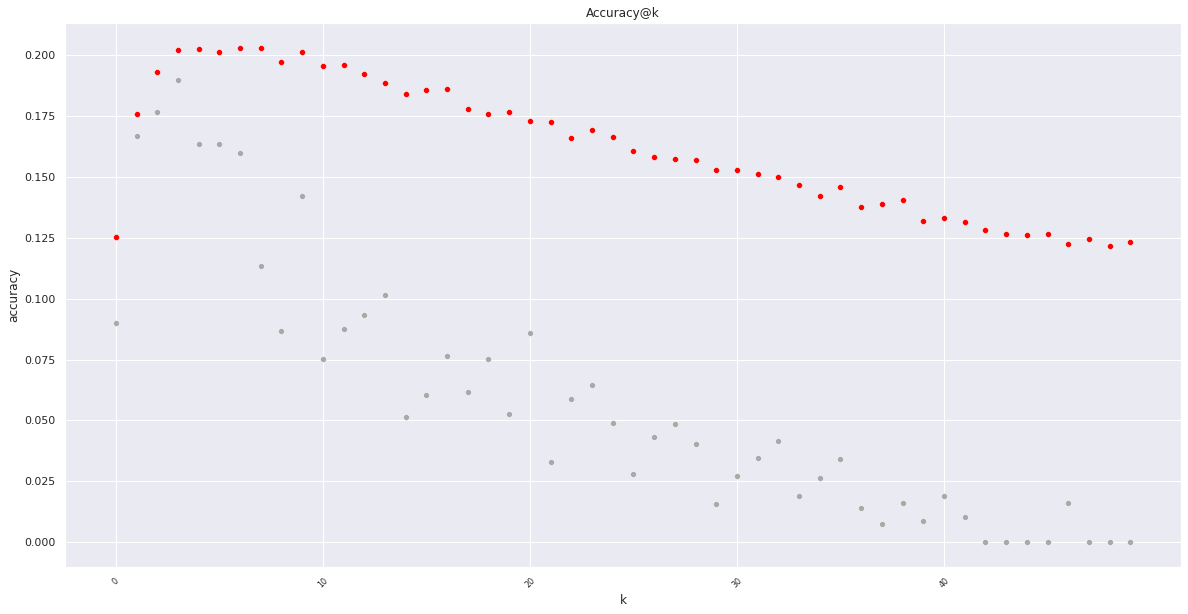

In [87]:
from metrics import accuracy_at_k
from visual_utils import plot_stats

def get_to_len(xs, len_):
    return [xs[i] if i<len(xs) else 0 for i in range(len_)]

accs_at_k = accuracy_at_k(l_pred_indices_per_k_best, y_indices, up_to_k=None)
accs_at_k_base = get_to_len(accuracy_at_k(l_pred_indices_per_k_base, y_indices_base, up_to_k=None), len(accs_at_k))



plot_stats(accs_at_k, baseline1D=accs_at_k_base, title="Accuracy@k", color="red", ylabel='accuracy', xlabel='k')

In [88]:
from metrics import accuracy_at_int

accs_at_int = accuracy_at_int(l_pred_indices_per_k_best, y_indices, X_intens)
accs_at_int_base = get_to_len(accuracy_at_int(l_pred_indices_per_k_base, y_indices_base, X_intens_base), len(accs_at_int))

/auto/brno6/home/xstary1/raims/metrics.py:169: RuntimeWarning: invalid value encountered in true_divide
  return corr_at_int / tot_at_int


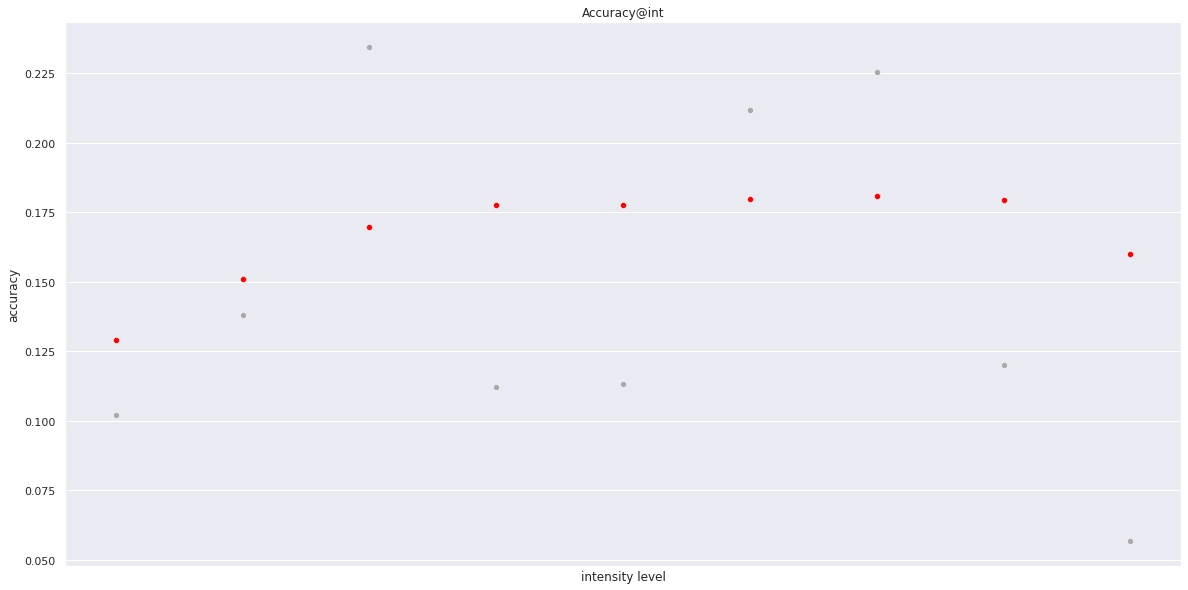

In [89]:
plot_stats(accs_at_int, baseline1D=accs_at_int_base, title="Accuracy@int", color="red", decreasing=True,  ylabel='accuracy', xlabel='intensity level', x_factor=.01)

In [90]:
sum(l_pred_indices_per_k_base[30][:,0] != -1)

183

In [91]:
to_rel_inten=.2
j=6
l=4
up_to_k=50

In [92]:
mean_prec, mean_jac, mean_prec_int, mean_jac_int = calc_mean_lj_metrics(l_pred_indices_per_k_best, y_indices, \
                                                                        X_intens, up_to_k=up_to_k, l=l, j=j, \
                                                                        l_rel=None, to_rel_inten=to_rel_inten)

mean_prec_base, mean_jac_base, mean_prec_int_base, mean_jac_int_base = calc_mean_lj_metrics(l_pred_indices_per_k_base, \
                                                                                            y_indices_base, X_intens_base, \
                                                                                            up_to_k=up_to_k, l=l, j=j,\
                                                                                            l_rel=None, to_rel_inten=to_rel_inten)

#mean_prec_base = get_to_len(mean_prec_base, len(mean_prec))
#mean_jac_base = get_to_len(mean_jac_base, len(mean_jac))

Possible k up to 50, predict up to 4 peaks
Selected up to k=50, l=4, j=6
[27908 27908 27908 27908 27908 27908 27908 27908 27908 27908 27852 27810
 27776 27724 27639 27553 27498 27419 27332 27249 27167 27067 26960 26862
 26751 26621 26509 26371 26245 26108 25967 25820 25672 25523 25345 25166
 24998 24832 24657 24479 24298 24141 23954 23738 23541 23370 23172 22975
 22761 22541]
[27908 27908 27908 27908 27908 27908 27908 27908 27908 27908 27852 27810
 27776 27724 27639 27553 27498 27419 27332 27249 27167 27067 26960 26862
 26751 26621 26509 26371 26245 26108 25967 25820 25672 25523 25345 25166
 24998 24832 24657 24479 24298 24141 23954 23738 23541 23370 23172 22975
 22761 22541]
Selected up to k=50, l=None, to_rel_inten=0.2
[27908 27872 27818 27720 27608 27489 27337 27179 26984 26767 26640 26471
 26251 26060 25924 25786 25568 25391 25250 25067 24860 24673 24502 24318
 24111 23926 23723 23552 23404 23217 23061 22897 22725 22570 22431 22277
 22097 21927 21760 21580 21400 21202 21065 20931 2

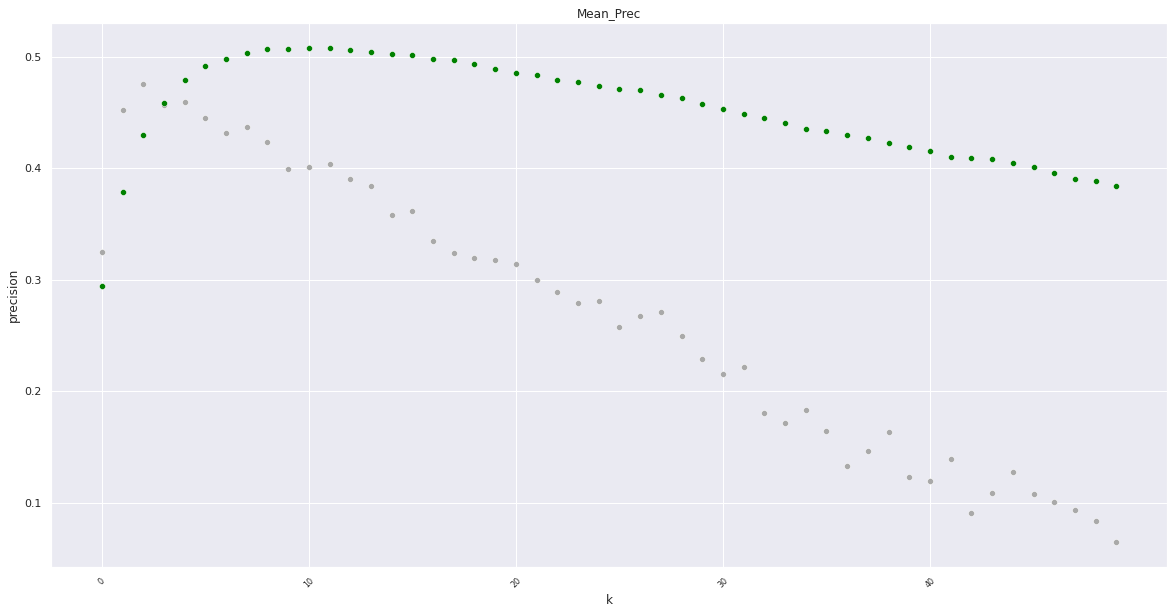

In [93]:
plot_stats(mean_prec, baseline1D=mean_prec_base, title="Mean_Prec", color="green", ylabel='precision', xlabel='k')

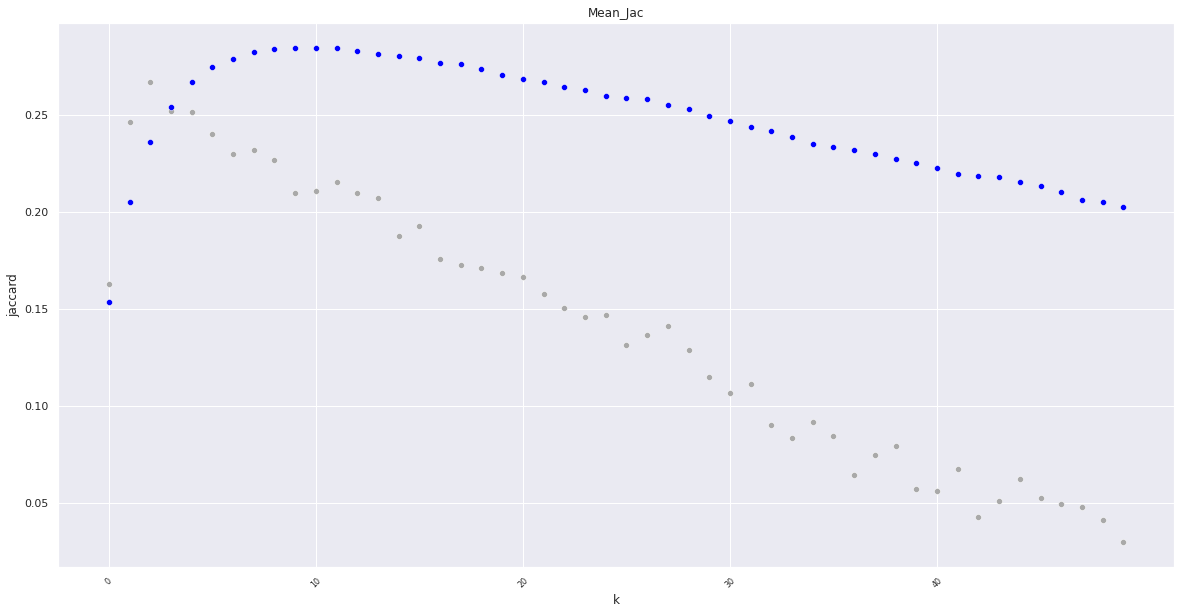

In [94]:
plot_stats(mean_jac, baseline1D=mean_jac_base, title="Mean_Jac", color="blue", ylabel='jaccard', xlabel='k')

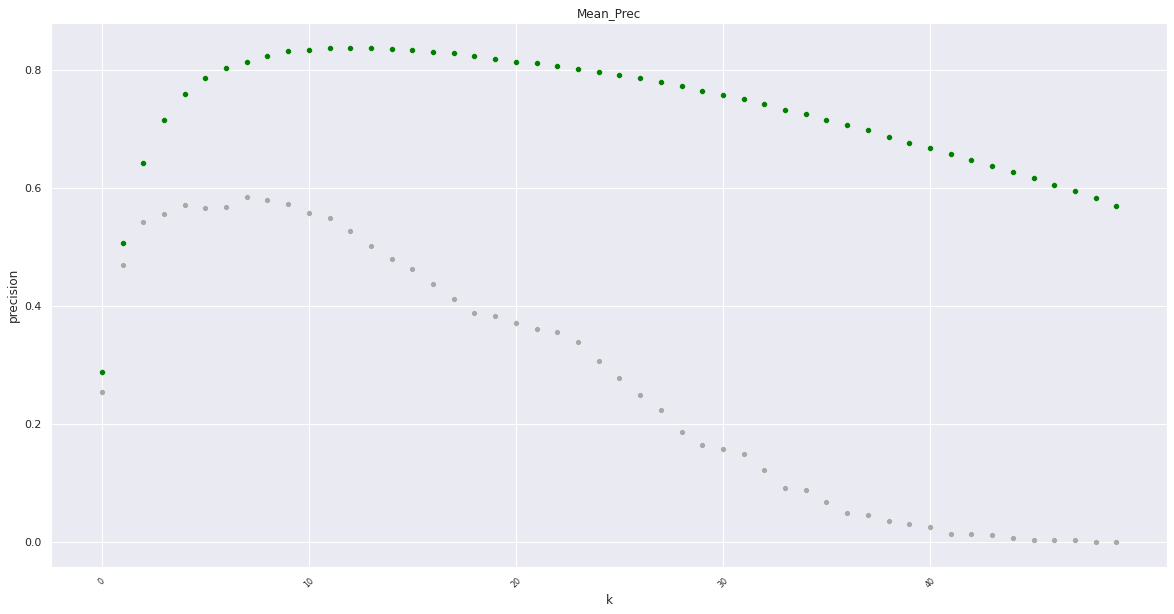

In [95]:
plot_stats(mean_prec_int, baseline1D=mean_prec_int_base, title="Mean_Prec", color="green", ylabel='precision', xlabel='k')

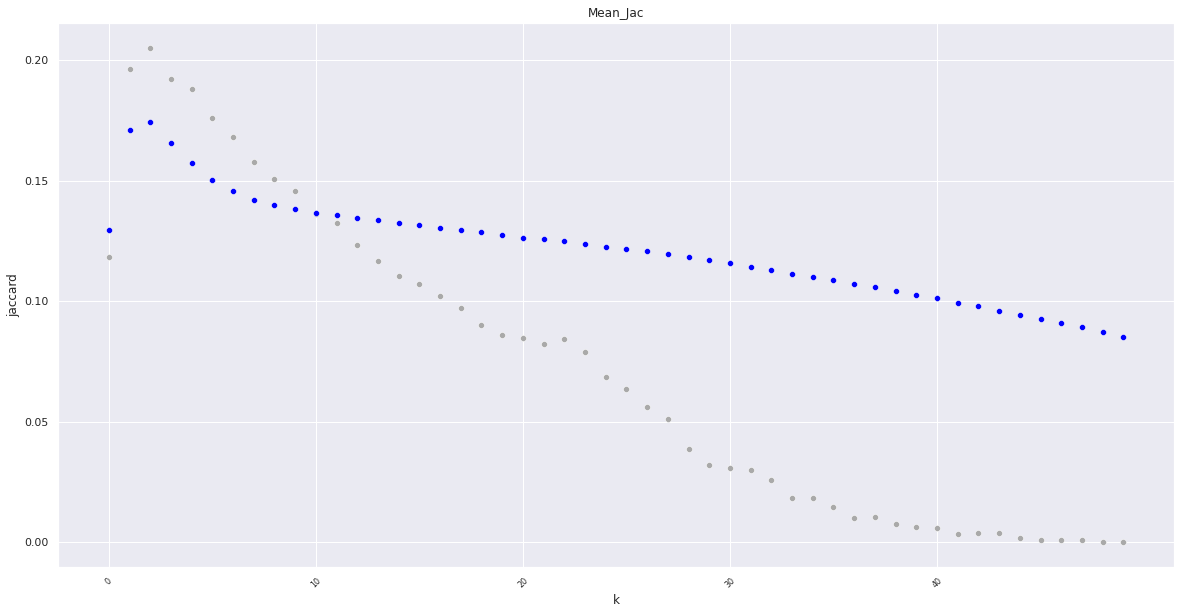

In [96]:
plot_stats(mean_jac_int, baseline1D=mean_jac_int_base, title="Mean_Jac", color="blue", ylabel='jaccard', xlabel='k')

In [ ]:
assert False

# End